In [ ]:
                                Global Power Plant Database
    Project Overview:
The Global Power Plant Database is a comprehensive, open source database of power plants around the world. 
It centralizes power plant data to make it easier to navigate, compare and draw insights for one’s own analysis.
The database covers approximately 14,000 power plants from 3 countries(USA, AUS, INDIA) and includes thermal plants.

Aim to make a two predictions for Primary fuel and capacity_mw.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   908 non-null    object 
 1   country_long              908 non-null    object 
 2   name                      908 non-null    object 
 3   gppd_idnr                 908 non-null    object 
 4   capacity_mw               908 non-null    float64
 5   latitude                  862 non-null    float64
 6   longitude                 862 non-null    float64
 7   primary_fuel              908 non-null    object 
 8   other_fuel1               199 non-null    object 
 9   other_fuel2               1 non-null      object 
 10  other_fuel3               0 non-null      float64
 11  commissioning_year        528 non-null    float64
 12  owner                     342 non-null    object 
 13  source                    908 non-null    object 
 14  url       

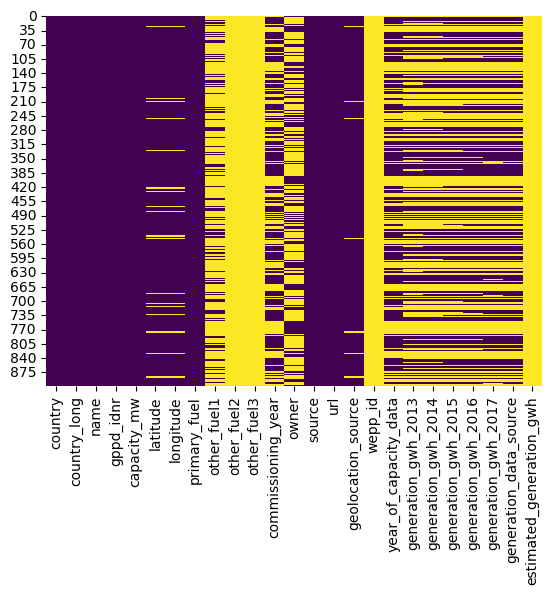

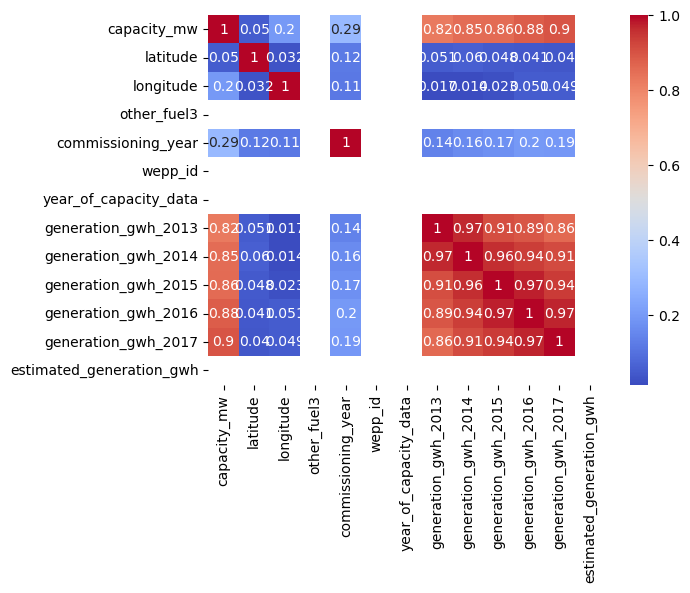

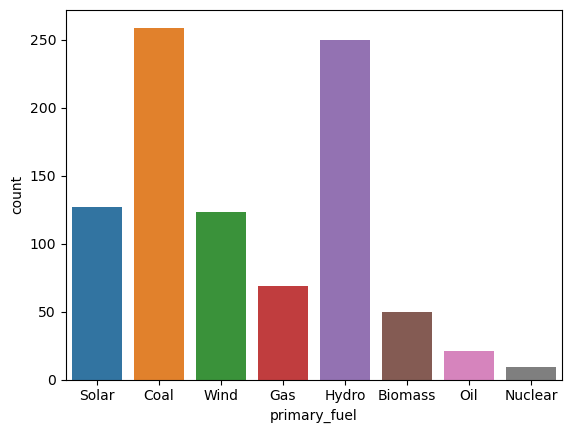

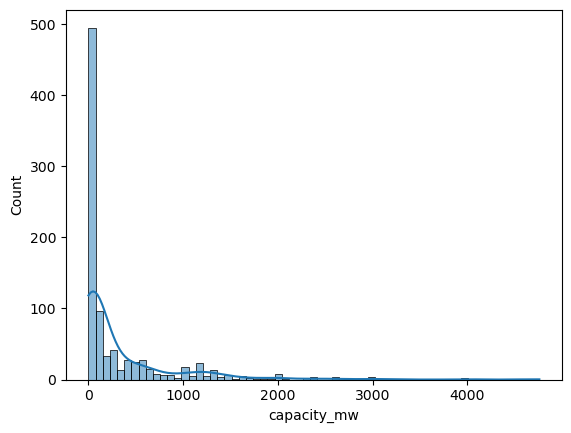

Checking for NaN values in training data:
latitude                      0
longitude                     0
other_fuel3                 635
commissioning_year            0
wepp_id                     635
year_of_capacity_data         0
generation_gwh_2013           0
estimated_generation_gwh    635
dtype: int64
Checking for infinite values in training data:
latitude                    0
longitude                   0
other_fuel3                 0
commissioning_year          0
wepp_id                     0
year_of_capacity_data       0
generation_gwh_2013         0
estimated_generation_gwh    0
dtype: int64
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.40      0.38        10
           1       0.81      0.75      0.78        84
           2       0.70      0.58      0.64        24
           3       0.83      0.88      0.85        81
           4       1.00      0.00      0.00         1
           5       0.20      0.12      0

In [6]:
# Import required libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import classification_report, mean_squared_error, r2_score, accuracy_score
import pickle

# Load the dataset
url = "https://raw.githubusercontent.com/dsrscientist/dataset3/main/global_Power_plant_database.csv"
data = pd.read_csv(url)

# 1. EDA - Basic insights
print(data.info())
print(data.describe())

# Visualizing missing values
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.show()

# Correlation matrix (Only numeric columns)
numeric_data = data.select_dtypes(include=[np.number])
corr = numeric_data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

# Distribution of target variables - primary_fuel, capacity_mw
sns.countplot(x='primary_fuel', data=data)
plt.show()

sns.histplot(data['capacity_mw'], kde=True)
plt.show()

# 2. Data Preprocessing
# Handling missing values by filling with column means for numeric and mode for categorical
data.fillna(data.mean(numeric_only=True), inplace=True)
for col in data.select_dtypes(include=[object]).columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Encoding categorical variables
label_enc = LabelEncoder()
data['primary_fuel'] = label_enc.fit_transform(data['primary_fuel'])

# 3. Feature Engineering
# Dropping irrelevant columns
columns_to_drop = ['gppd_idnr', 'name', 'country_long', 'source', 'owner', 'url', 'geolocation_source']
data = data.drop(columns=columns_to_drop, axis=1)

# Handling potential multicollinearity, removing highly correlated features
threshold = 0.85
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
data = data.drop(columns=to_drop, axis=1)

# Splitting the dataset for two tasks: classification & regression
X = data.drop(['primary_fuel', 'capacity_mw'], axis=1)
y_classification = data['primary_fuel']
y_regression = data['capacity_mw']

# 4. Splitting for model building
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_classification, test_size=0.3, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()

# Ensure we scale only the numeric columns
X_train_class_numeric = X_train_class.select_dtypes(include=[np.number])
X_test_class_numeric = X_test_class.select_dtypes(include=[np.number])
X_train_reg_numeric = X_train_reg.select_dtypes(include=[np.number])
X_test_reg_numeric = X_test_reg.select_dtypes(include=[np.number])

# Check for NaN or infinite values
print("Checking for NaN values in training data:")
print(X_train_class_numeric.isnull().sum())
print("Checking for infinite values in training data:")
print(np.isinf(X_train_class_numeric).sum())

# Fill any remaining NaN values and replace infinite values
X_train_class_numeric.fillna(0, inplace=True)
X_test_class_numeric.fillna(0, inplace=True)
X_train_reg_numeric.fillna(0, inplace=True)
X_test_reg_numeric.fillna(0, inplace=True)
X_train_class_numeric.replace([np.inf, -np.inf], 0, inplace=True)
X_test_class_numeric.replace([np.inf, -np.inf], 0, inplace=True)
X_train_reg_numeric.replace([np.inf, -np.inf], 0, inplace=True)
X_test_reg_numeric.replace([np.inf, -np.inf], 0, inplace=True)

# Ensure we still have data after filling missing values
if X_train_class_numeric.empty:
    raise ValueError("No data available for training after handling NaN or infinite values.")

# Feature Scaling
X_train_class_scaled = scaler.fit_transform(X_train_class_numeric)
X_test_class_scaled = scaler.transform(X_test_class_numeric)
X_train_reg_scaled = scaler.fit_transform(X_train_reg_numeric)
X_test_reg_scaled = scaler.transform(X_test_reg_numeric)

# Create DataFrames with the scaled data using original column names
X_train_class = pd.DataFrame(X_train_class_scaled, columns=X_train_class_numeric.columns)
X_test_class = pd.DataFrame(X_test_class_scaled, columns=X_test_class_numeric.columns)
X_train_reg = pd.DataFrame(X_train_reg_scaled, columns=X_train_reg_numeric.columns)
X_test_reg = pd.DataFrame(X_test_reg_scaled, columns=X_test_reg_numeric.columns)

# 5. Model Building - Classification (Primary Fuel)
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_class, y_train_class)

# Model Evaluation - Classification with zero_division parameter
y_pred_class = rf_classifier.predict(X_test_class)
print("Classification Report:\n", classification_report(y_test_class, y_pred_class, zero_division=1))  # Set zero_division to 1 or 0
print("Accuracy:", accuracy_score(y_test_class, y_pred_class))


# 6. Model Building - Regression (Capacity MW)
lr_regressor = LinearRegression()
lr_regressor.fit(X_train_reg, y_train_reg)

# Model Evaluation - Regression
y_pred_reg = lr_regressor.predict(X_test_reg)
print("Mean Squared Error:", mean_squared_error(y_test_reg, y_pred_reg))
print("R-squared:", r2_score(y_test_reg, y_pred_reg))

# 7. Hyperparameter Tuning (Grid Search CV for Random Forest)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_class, y_train_class)
print("Best parameters found: ", grid_search.best_params_)

# 8. Retrain with best parameters
best_rf_classifier = grid_search.best_estimator_
best_rf_classifier.fit(X_train_class, y_train_class)
y_pred_best_class = best_rf_classifier.predict(X_test_class)
print("Best Model Accuracy (Classification):", accuracy_score(y_test_class, y_pred_best_class))

# Hyperparameter tuning for Linear Regression (Ridge Regression as tuning example)
ridge_reg = Ridge()
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0]}
ridge_search = GridSearchCV(ridge_reg, param_grid_ridge, cv=5)
ridge_search.fit(X_train_reg, y_train_reg)
print("Best parameters for Ridge:", ridge_search.best_params_)

# 9. Save the best model (Random Forest for classification)
with open('best_rf_classifier.pkl', 'wb') as f:
    pickle.dump(best_rf_classifier, f)

# Save best regression model (Ridge Regression)
with open('best_ridge_regressor.pkl', 'wb') as f:
    pickle.dump(ridge_search.best_estimator_, f)


In [ ]:
Process steps:
Load Dataset: The dataset is loaded directly from a URL.
Exploratory Data Analysis (EDA): Basic insights are obtained, missing values are visualized, and correlations are explored.
Data Preprocessing:
Missing values are filled.
Categorical variables are encoded.
Feature Engineering:
Irrelevant columns are dropped.
Highly correlated features are removed.
Splitting Data:
The dataset is split for both classification and regression tasks.
Model Building:
Classification: RandomForestClassifier is used to predict primary fuel type.
Regression: LinearRegression is used to predict power capacity.
Model Evaluation:
Classification metrics include accuracy and classification report.
Regression metrics include mean squared error and R-squared.
Hyperparameter Tuning:
GridSearchCV is used to find the best parameters for both classification and regression models.
Model Saving:
The best models are saved using pickle for future use.